# Quantum jump duration estimation from direct deconvolution of signal

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from uncertainties import unumpy
from uncertainties import ufloat

%matplotlib inline

## Signal import and frequency analysis

In [2]:
data_file = 'data/raw_data/selected_g2/20170529_FWMg2_MPD_MPDGated_4GHzOsci_4MHzBlueDetuned.dat'

# import oscilloscope data into time and counts vectors. cut off the edges
Dt, counts = np.flipud(np.genfromtxt(data_file, skip_header=5, delimiter=',')).T
Dt_step = np.abs(np.mean(np.diff(Dt)))

# usable_range = range(len(Dt))
usable_range = range(543, 4994)
counts = counts[usable_range]
Dt = -Dt[usable_range]

counts_err = np.sqrt(counts)
counts_u = unumpy.uarray(counts, counts_err)
print('Time resolution: {:.3e}'.format(Dt_step))

Time resolution: 1.000e-11


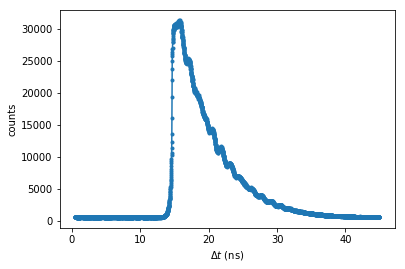

In [3]:
plt.figure('FWM data, time resolution: {:.3g} ns'.format(np.mean(np.diff(Dt))* 1e9))
plt.plot(Dt*1e9, counts, '.-')
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts');

## Detector transfer function

In [ ]:
from lmfit import Model
from lmfit import Parameters
from lmfit.models import ConstantModel
from lmfit.models import ExponentialModel
from lmfit.models import GaussianModel
from lmfit.models import LorentzianModel

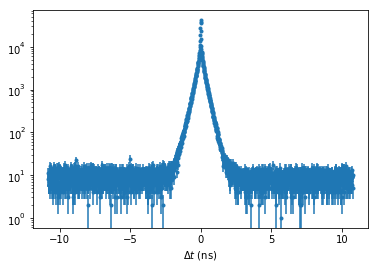

In [4]:
mpd_datafile = 'data/raw_data/MPD_characterization/F1pmp1actrigger.txt'
Dt_mpd, counts_mpd = np.genfromtxt(mpd_datafile, delimiter=',', skip_header=5).T
Dt_mpd_step = np.mean(np.diff(Dt_mpd))

# drop zero bins and center the MPD response function
peak_idx = np.argmax(counts_mpd)
mpd_center = counts_mpd[4:peak_idx + (peak_idx - 5)]
mpd_t = (np.arange(len(mpd_center)) - len(mpd_center)//2 - 1) * Dt_mpd_step

# poissonian error
mpd_error = np.sqrt(mpd_center)

# sets the floor range where accidental counts are the main component
flat_range = list(range(500)) + list(range(len(mpd_t)-500, len(mpd_t)))

plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, fmt='.')
plt.xlabel(r'$\Delta t$ (ns)');
plt.yscale('log')

### Baseline removal

[[Model]]
    (((Model(constant, prefix='offset_') + Model(exponential, prefix='a_')) + Model(exponential, prefix='b_')) + Model(gaussian, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 308
    # data points      = 2159
    # variables        = 8
    chi-square         = 5282.05013
    reduced chi-square = 2.45562535
    Akaike info crit   = 1947.59070
    Bayesian info crit = 1993.00991
[[Variables]]
    offset_c:     7.81887519 +/- 0.10471039 (1.34%) (init = 1)
    a_decay:      0.27442600 +/- 0.00161536 (0.59%) (init = 1)
    a_amplitude:  6539.88187 +/- 95.2736513 (1.46%) (init = 100)
    b_decay:      0.06780135 +/- 0.00298675 (4.41%) (init = 1)
    b_amplitude:  7305.58025 +/- 303.999090 (4.16%) (init = 100)
    c_sigma:      0.01826659 +/- 4.0790e-04 (2.23%) (init = 0.1)
    c_center:    -0.00112182 +/- 6.4523e-04 (57.52%) (init = 0)
    c_amplitude:  1275.56665 +/- 49.8442384 (3.91%) (init = 1000)
    c_fwhm:       0.04301454 +/- 9.60

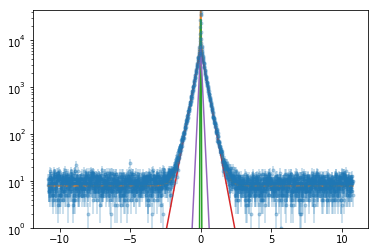

In [5]:
# Model of the detector response
response_model = (ConstantModel(prefix='offset_') +
                  ExponentialModel(prefix='a_') +
                  ExponentialModel(prefix='b_')  +
                  GaussianModel(prefix='c_')
                 )

p_peak = response_model.make_params()
p_peak['offset_c'].set(value=min(mpd_center))
p_peak['a_decay'].set(value=1)
p_peak['a_amplitude'].set(value=1e2)
p_peak['b_decay'].set(value=1)
p_peak['b_amplitude'].set(value=1e2)
p_peak['c_amplitude'].set(value=1e3)
p_peak['c_sigma'].set(value=.1)
p_peak['c_center'].set(value=0, vary=1)

mpd_result = response_model.fit(mpd_center,
                                x=np.abs(mpd_t * 1e9),
                                params=p_peak,
                                weights=1 / mpd_error
                               )
print(mpd_result.fit_report())
comps = mpd_result.eval_components()
plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, alpha=.3, fmt='.')
plt.plot(mpd_t * 1e9, mpd_result.best_fit);
plt.plot(mpd_t * 1e9, comps['c_']);
plt.plot(mpd_t * 1e9, comps['a_']);
plt.plot(mpd_t * 1e9, comps['b_']);
plt.ylim(min(mpd_center))
plt.yscale('log')

In [6]:
# Defining the normalized response function, including errors
mpd_counts_u = unumpy.uarray(mpd_center, mpd_error) - ufloat(mpd_result.params['offset_c'].value,
                                                      mpd_result.params['offset_c'].stderr)

# normalization
norm_u = np.sum(mpd_counts_u)
mpd_u = mpd_counts_u / norm_u
mpd_error = unumpy.std_devs(mpd_u)
mpd = unumpy.nominal_values(mpd_u)

### Match length of signal and detector response

In [7]:
# match length of signal and detector response
l_signal = len(counts)
l_mpd = len(mpd)
extension = np.zeros(int((l_signal-l_mpd) / 2))
mpd_ex = np.concatenate((extension, mpd, extension))
mpd_error_ex = np.concatenate((extension, mpd_error, extension))
print('Signal lengt: {}, New response vector length: {}'.format(l_signal, len(mpd_ex)))

Signal lengt: 4451, New response vector length: 4451


## Deconvolution

In [ ]:
from numpy.fft import rfft
from numpy.fft import rfftfreq
from numpy.fft import irfft

In [206]:
# Low pass exponential filter
def winn(x, cutoff):
    retval = np.exp(-x / cutoff)
    retval /= retval[0]
    return retval


def deconvolution(signal, det_response, winn=None, normalize=False):
    signal_fft = rfft(signal)
    if normalize:
        signal_fft /= signal_fft[0]
    det_fft = rfft(det_response)
    det_fft /= det_fft[0]
    if winn is not None:
        signal_fft = signal_fft * winn
    return irfft(signal_fft / det_fft)

### Bootstrapping

In [208]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 1   # arbitrary default
print('Numbe rof CPU to use for multi-processing {}'.format(cpus))

Numbe rof CPU to use for multi-processing 4


In [209]:
# Filter definition
cutoff = 400
winn_vec = winn(np.arange(np.ceil(l_signal/2)), cutoff)

# sampling using Poissonian statistics
samples = 1e3
counts_prop = np.array([np.random.poisson(k, int(samples)) for k in counts]).T

# applying the deconvolution for every sample
with multiprocessing.Pool(cpus) as pool:
    def obj_f(x):
        return deconvolution(x, mpd_ex, winn_vec)

    dec_prop = pool.map(obj_f, counts_prop)

# reshape the 
dec_prop = np.array(dec_prop).T

# extract the resulting deconvoluted signal and corresponding error
tt = np.mean(dec_prop, 1)
tt_err = np.std(dec_prop, 1)

# fix for the rollover of the inverse fourier transform
tt = np.concatenate((tt[len(tt) // 2:], tt[:len(tt) // 2 + 1]))
tt_err = np.concatenate(
    (tt_err[len(tt_err) // 2:], tt_err[:len(tt_err) // 2 + 1]))

<IPython.core.display.Javascript object>


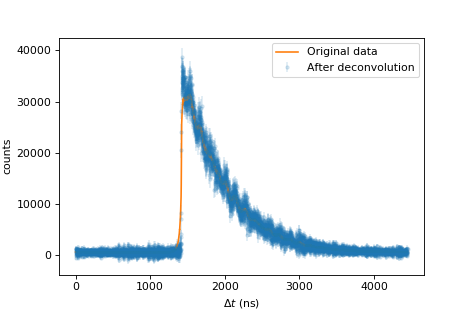

In [210]:
plt.figure(
    'Comparison of time correlation before and after deconvolution with detectors response')
plt.errorbar(np.arange(len(tt)),
             tt,
             yerr=tt_err,
             fmt='.',
             alpha=.15,
             label='After deconvolution')
plt.plot(counts, '-', label='Original data')
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts')
plt.legend();

## Fitting

### Fit function

In [211]:
def jump(x, alpha):
    # rising edge
    return 1 / (1 + np.exp(- x / alpha))


def rise_decay_f(x, alpha, t0, tau):
    x = x - t0
    retval = jump(x, alpha) * np.exp(-x / tau)
    return retval / max(retval)


def rise_time(alpha):
    # return 90/10 rise time from the edge
    c = np.log(1.8/.2) / 2
    return alpha * c * 4


# fit model from function
rise_decay_model = ConstantModel(prefix='amplitude_') * Model(rise_decay_f) + ConstantModel(prefix='offset_')

### Parameter choice and results

90/10 rise time from fit: 0.0665+/-0.0044 ns

[[Model]]
    ((Model(constant, prefix='amplitude_') * Model(rise_decay_f)) + Model(constant, prefix='offset_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 4451
    # variables        = 5
    chi-square         = 3550.29441
    reduced chi-square = 0.79853675
    Akaike info crit   = -996.363348
    Bayesian info crit = -964.358928
[[Variables]]
    alpha:        0.01514037 +/- 9.9279e-04 (6.56%) (init = 0.1)
    t0:           14.6227926 +/- 0.00113763 (0.01%) (init = 14)
    tau:          5.47051656 +/- 0.02258558 (0.41%) (init = 6)
    offset_c:     410.504615 +/- 11.4165807 (2.78%) (init = 522.8157)
    amplitude_c:  36124.6592 +/- 129.947234 (0.36%) (init = 38706.59)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, amplitude_c)      = -0.625
    C(tau, offset_c)         = -0.508
    C(alpha, amplitude_c)    = -0.228
    C(offset_c, amplitude_c) =  0.128
    C

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


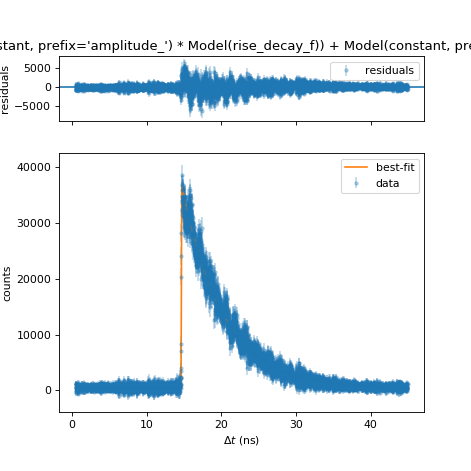

In [218]:
p = Parameters()
p.add('alpha', .1)
p.add('t0', 14)
p.add('tau', 6)
p.add('offset_c', np.mean(tt[:200]), vary=1)
p.add('amplitude_c', max(tt))

fit_result = rise_decay_model.fit(tt, x=Dt*1e9, params=p, weights= 1 / tt_err)

print('90/10 rise time from fit: {:.2u} ns\n'.format(rise_time(ufloat(fit_result.params['alpha'].value,
                                                                      fit_result.params['alpha'].stderr))))
print(fit_result.fit_report())
fit_result.plot(xlabel=r'$\Delta t$ (ns)',
                ylabel='counts',
                datafmt='.',
                data_kws={'alpha':.3});

## Save data to file

In [133]:
with open('data/processed_data/quantum-jump_deconvolution.dat', 'w') as f:
    f.write('#Dt\tcounts\tcounts_err\t'
            'deconv\tdeconv_err\t'
            'fit\tfit_uncert\n')
    [f.write(('{}\t'*6 + '{}\n').format(t, c, c_e, dc, dc_e, ff, ff_e))
     for t, c, c_e, dc, dc_e, ff, ff_e
     in zip(Dt*1e9, counts, counts_err, tt, tt_err, fit_result.best_fit, dely)]

## Analysis of the effect of the filter characteristic frequency 

The previous section was repeated for different values of `cutoff` to observe how the filter affect the estimated duration of the jump

In [133]:
cutoffs = [200,
           300,
           350,
           400,
           450,
           500,
           550,
           600,
           650,
           700]

alphas = [0.03863482,
          0.02259058,
          0.01832522,
          0.01528771,
          0.01300014,
          0.01117608,
          0.00945013,
          0.00821871,
          0.00694958,
          6.3628E-04]

alphas_err = [7.7571E-04,
              5.9585E-04,
              7.2571E-04,
              0.00100046,
              0.00133600,
              0.00177284,
              0.00209704,
              0.00245997,
              0.00286602,
              0.55922264]

<IPython.core.display.Javascript object>


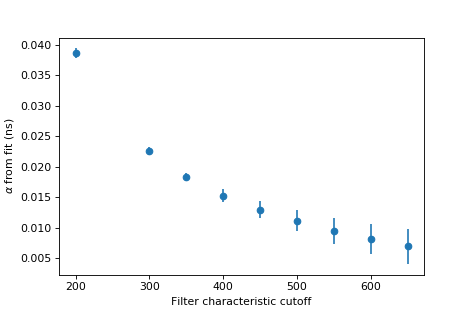

In [215]:
%matplotlib notebook
plt.figure()
plt.errorbar(cutoffs[:-1], alphas[:-1], yerr=alphas_err[:-1], fmt='o')
plt.xlabel('Filter characteristic cutoff')
plt.ylabel(r'$\alpha$ from fit (ns)');

<IPython.core.display.Javascript object>


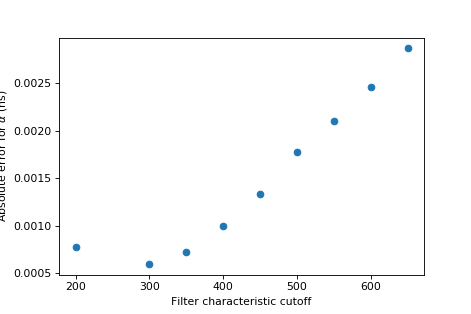

In [216]:
plt.figure()
plt.plot(cutoffs[:-1], alphas_err[:-1], 'o')
plt.xlabel('Filter characteristic cutoff')
plt.ylabel(r'Absolute error of $\alpha$ (ns)');

<IPython.core.display.Javascript object>


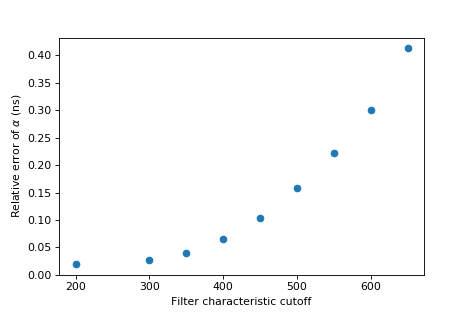

In [217]:
plt.figure()
plt.plot(cutoffs[:-1], np.array(alphas_err[:-1]) / np.array(alphas[:-1]), 'o')
plt.xlabel('Filter characteristic cutoff')
plt.ylabel(r'Relative error of $\alpha$ (ns)');